**Installing the dependacies: **

In [1]:
!pip install -q pandas scikit-learn matplotlib google-generativeai tqdm joblib

Dataset download:

In [4]:
#from pathlib import Path
#import urllib.request, zipfile
import zipfile

In [5]:
zip_path = r"/content/sentiment+labelled+sentences.zip"
extract_dir = "data"
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

print("Extracted to:", extract_dir)

Extracted to: data


In [6]:
import pandas as pd

In [8]:
df = pd.read_csv(
    "data/sentiment labelled sentences/amazon_cells_labelled.txt",
    sep="\t", header=None, names=["review", "sentiment"])
print("Dataset shape:", df.shape)

Dataset shape: (1000, 2)


In [9]:
df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


Test-Train splitting:

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    df["review"], df["sentiment"],
    test_size=0.2, random_state=42, stratify=df["sentiment"]
)

In [12]:
print("Train size:", len(x_train), "Test size:", len(x_test))

Train size: 800 Test size: 200


Classical ML pipeline:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

TF-IDF

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words="english", max_features=3000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

Training the classifier:

In [17]:
clf = LogisticRegression(max_iter=500)
clf.fit(x_train_vec, y_train)

LogisticRegression(max_iter=500)

prediction:

In [19]:
y_pred = clf.predict(x_test_vec)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1])

In [20]:
print(classification_report(y_test, y_pred, target_names=["NEGATIVE","POSITIVE"]))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.75      0.77       100
    POSITIVE       0.76      0.80      0.78       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



Confusion matrix:

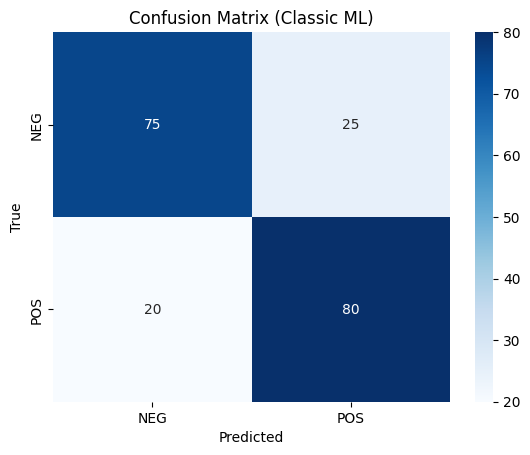

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NEG","POS"], yticklabels=["NEG","POS"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Classic ML)")
plt.show()

Saving the model by joblib library:

In [22]:
import joblib
from pathlib import Path

In [23]:
model = Path("models")
model.mkdir(exist_ok=True)

joblib.dump(vectorizer, model/ "vectorizer.joblib")
joblib.dump(clf, model / "logreg.joblib")

['models/logreg.joblib']

In [24]:
print("Saved model in:", model)

Saved model in: models


Test:

In [25]:
def classic_predict(text: str):
    v = joblib.load("models/vectorizer.joblib")
    c = joblib.load("models/logreg.joblib")
    label = c.predict(v.transform([text]))[0]
    return "POSITIVE" if label == 1 else "NEGATIVE"


In [26]:
print(classic_predict("Absolutely loved it — works great!"))
print(classic_predict("Terrible product, wasted my money."))

POSITIVE
NEGATIVE


using gemini API key:

In [27]:
from getpass import getpass
import os

os.environ["GOOGLE_API_KEY"] = getpass("Enter your Gemini API key: ")

Enter your Gemini API key: ··········


In [28]:
import google.generativeai as genai

In [29]:
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")


In [30]:
# quick test
resp = model.generate_content('Say "hello" as JSON: {"msg": "hello"}')
print(resp.text)

```json
{"msg": "hello"}
```



In [31]:
import json, time

In [32]:
sys_prompt = (
    "You are a strict sentiment classifier. "
    "Respond ONLY in JSON with key 'label' as either 'POSITIVE' or 'NEGATIVE'."
)

def classify_with_gemini(text, retries=2):
    prompt = sys_prompt + f'\n\nReview: "{text}"\nAnswer: '
    for attempt in range(retries):
        try:
            resp = model.generate_content(prompt)
            raw = resp.text.strip()
            try:
                obj = json.loads(raw)
                label = obj.get("label", "").upper()
                if label in {"POSITIVE","NEGATIVE"}:
                    return label
            except:
                pass
            # fallback
            return "POSITIVE" if "posit" in raw.lower() else "NEGATIVE"
        except Exception as e:
            print("Error:", e, "retrying...")
            time.sleep(1)
    return "NEGATIVE"


In [33]:
sample_reviews = [
    "Great product! Works perfectly and very fast.",
    "The battery life is terrible but the screen is nice.",
    "I regret buying this. It broke after two days."
]

In [34]:
for review in sample_reviews:
    print(f"Review: {review}")
    print("Gemini prediction:", classify_with_gemini(review))
    print()


Review: Great product! Works perfectly and very fast.
Gemini prediction: POSITIVE

Review: The battery life is terrible but the screen is nice.
Gemini prediction: NEGATIVE

Review: I regret buying this. It broke after two days.
Gemini prediction: NEGATIVE



In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [36]:
n = 20
texts = x_test.iloc[:n].tolist()
true_labels = y_test.iloc[:n].tolist()

In [37]:
preds = [1 if classify_with_gemini(t)=="POSITIVE" else 0 for t in texts]

Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. retrying...
Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) retrying...


In [38]:
#accuracy score:
acc = accuracy_score(true_labels, preds)
p, r, f1, _ = precision_recall_fscore_support(true_labels, preds, average="weighted")
print({"accuracy": acc, "precision": p, "recall": r, "f1": f1})

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
